# PPO Clip Visualization

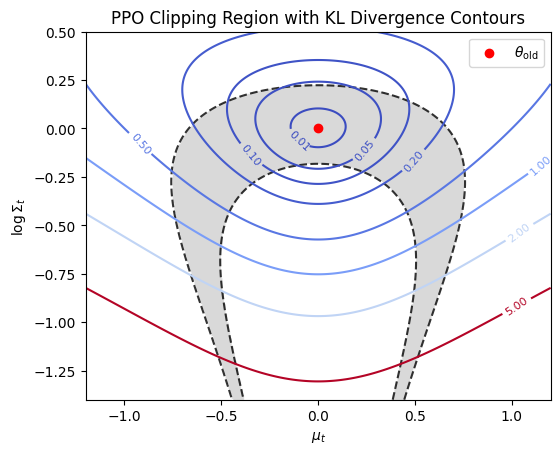

In [50]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters (example values similar to PPO paper)
mu_old = 0.0           # old policy mean
log_std_old = 0.0      # old policy log std (σ_old = 1)
sigma_old = np.exp(log_std_old)

a_t = 0.0              # action taken
eps = 0.2              # PPO clip epsilon

# Grid for μ_t and log σ_t
mu_range = np.linspace(-1.2, 1.2, 300)
log_std_range = np.linspace(-1.4, 0.5, 300)
MU, LOG_STD = np.meshgrid(mu_range, log_std_range)
SIGMA = np.exp(LOG_STD)

# Compute log r_t
log_r = (log_std_old - LOG_STD) + \
        ((a_t - mu_old)**2) / (2 * sigma_old**2) - \
        ((a_t - MU)**2) / (2 * SIGMA**2)

# Clip bounds in log space
lower_bound = np.log(1 - eps)
upper_bound = np.log(1 + eps)

# Region mask
mask = (log_r >= lower_bound) & (log_r <= upper_bound)

# Compute KL divergence D_KL( pi_old || pi_new ) for Gaussian policies
KL = np.log(SIGMA / sigma_old) + \
     (sigma_old**2 + (MU - mu_old)**2) / (2 * SIGMA**2) - 0.5

# Plot with KL contours
plt.figure(figsize=(6,6))
plt.contour(MU, LOG_STD, log_r, levels=[lower_bound, upper_bound],
            colors='k', linestyles='--', linewidths=1.5, alpha=0.8)
plt.imshow(1-mask, extent=[mu_range.min(), mu_range.max(), log_std_range.min(), log_std_range.max()],
           origin='lower', alpha=0.15, cmap='gray')

# KL divergence contours
kl_levels = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
contours = plt.contour(MU, LOG_STD, KL, levels=kl_levels, cmap='coolwarm')
plt.clabel(contours, inline=True, fontsize=8, fmt="%.2f")

# Mark theta_old
plt.scatter(mu_old, log_std_old, color='red', label=r'$\theta_{\mathrm{old}}$')
plt.xlabel(r'$\mu_t$')
plt.ylabel(r'$\log \Sigma_t$')
plt.legend()
plt.title("PPO Clipping Region with KL Divergence Contours")
plt.show()


# Max Tanh Gaussian Distribution Entropy

In [51]:
import matplotlib.pyplot as plt
import numpy as np

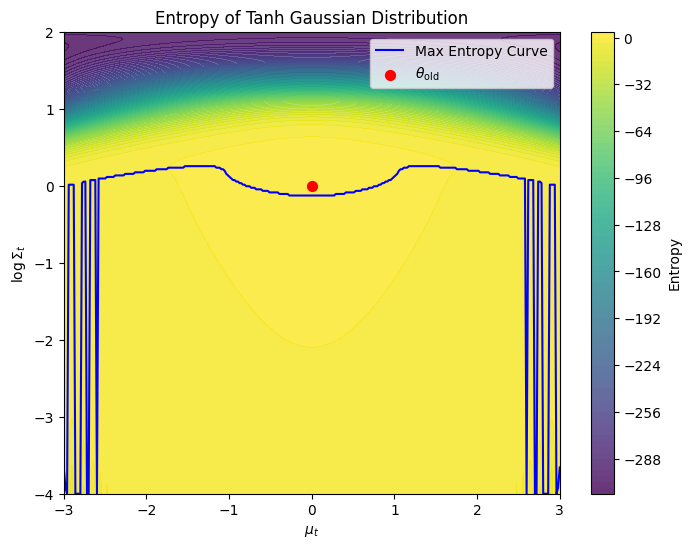

In [52]:
mu_range = np.linspace(-3, 3, 300)
log_std_range = np.linspace(-4, 2, 300)
MU, LOG_STD = np.meshgrid(mu_range, log_std_range)
SIGMA = np.exp(LOG_STD)

def gaussian_pdf(x, mu, log_std):
    sigma = np.exp(log_std)
    z = (x - mu) / sigma
    return 0.5 * np.exp(-0.5 * z**2) / (sigma * np.sqrt(2 * np.pi))

def tanh_gaussian_pdf(x, mu, log_std):
    return gaussian_pdf(np.arctanh(x), mu, log_std) / (1 - x**2)

def entropy_tanh_gaussian(mu, log_std):
    N, M = mu.shape
    assert N == M, "MU and LOG_STD must be square matrices of the same shape"
    
    K = 1000  # Number of points for numerical integration
    x = np.linspace(-1.0 + 1e-6, 1.0 - 1e-6, K)
    
    MU_exp = mu[..., np.newaxis]            # (N, N, 1)
    LOG_STD_exp = log_std[..., np.newaxis]  # (N, N, 1)
    x_exp = x[np.newaxis, np.newaxis, :]    # (1, 1, K)

    MU_broadcast = np.broadcast_to(MU_exp, (N, N, K))
    LOG_STD_broadcast = np.broadcast_to(LOG_STD_exp, (N, N, K))
    x_broadcast = np.broadcast_to(x_exp, (N, N, K))
    
    pdf_values = tanh_gaussian_pdf(x_broadcast, MU_broadcast, LOG_STD_broadcast)

    # Entropy is calculated as -∫ p(x) log(p(x)) dx
    entropy = -np.sum(pdf_values * np.log(pdf_values + 1e-10), axis=-1) * (x[1] - x[0])
    return entropy

entropy_values = entropy_tanh_gaussian(MU, LOG_STD)
log_sigma_for_max_entropy = log_std_range[np.argmax(entropy_values, axis=0)]
plt.figure(figsize=(8, 6))
plt.contourf(MU, LOG_STD, entropy_values, levels=100, cmap='viridis', alpha=0.8)
plt.plot(MU[0, :], log_sigma_for_max_entropy, color='blue', label='Max Entropy Curve')
plt.colorbar(label='Entropy')
plt.xlabel(r'$\mu_t$')
plt.ylabel(r'$\log \Sigma_t$')
plt.title('Entropy of Tanh Gaussian Distribution')
plt.scatter(0.0, 0.0, color='red', label=r'$\theta_{\mathrm{old}}$', s=50)
plt.legend()
plt.show()

In [55]:
entropy_values.argmax()

np.int64(58049)

# Opimal Parameters Fast Entorpy

- k-dimensional
- N parameters
- Optimized for gradients of entropy

In [37]:
import jax
import jax.numpy as jnp
import optax
import tqdm
import matplotlib.pyplot as plt

In [38]:
# Initialize samples
key = jax.random.PRNGKey(0)
n_samples = 8
dim = 1  # Dimension of the distribution
mu_range = (-3.0, 3.0)
std_range = (0.1, 5.0)
dataset_size = 4096

In [39]:
# Generate a dataset of mu and std values
key, subkey1, subkey2 = jax.random.split(key, 3)
means = jax.random.uniform(subkey1, (dataset_size, dim), minval=mu_range[0], maxval=mu_range[1])
stds_diag = jax.random.uniform(subkey2, (dataset_size, dim), minval=std_range[0], maxval=std_range[1])

@jax.jit
def true_entropy_batch(means, stds_diag, keys):
    def single_entropy(mu, std_diag, key):
        samples = mu + std_diag * jax.random.normal(key, (n_samples, dim))
        log_det_jacobian = jnp.sum(jnp.log(1 - jnp.tanh(samples) ** 2 + 1e-6), axis=-1)
        gauss_entropy = 0.5 * dim * (jnp.log(2 * jnp.pi * jnp.e)) + jnp.sum(jnp.log(std_diag))
        return gauss_entropy + jnp.mean(log_det_jacobian)
    return jax.vmap(single_entropy)(means, stds_diag, keys)

@jax.jit
def true_entropy_gradients_batch(means, stds_diag, keys):
    def single_entropy(mu, std_diag, key):
        samples = mu + std_diag * jax.random.normal(key, (n_samples, dim))
        log_det_jacobian = jnp.sum(jnp.log(1 - jnp.tanh(samples) ** 2 + 1e-6), axis=-1)
        gauss_entropy = 0.5 * dim * (jnp.log(2 * jnp.pi * jnp.e)) + jnp.sum(jnp.log(std_diag))
        entropy = gauss_entropy + jnp.mean(log_det_jacobian)
        return entropy
    # Compute gradients
    grad_mu, grad_std_diag = jax.vmap(jax.grad(single_entropy, argnums=(0, 1)))(means, stds_diag, keys)
    return grad_mu, grad_std_diag 

# Generate keys
key, subkey = jax.random.split(key)
subkeys = jax.random.split(subkey, dataset_size)
true_entropies = true_entropy_batch(means, stds_diag, subkeys)
true_entropy_grads_mu, true_entropy_grads_std_diag = true_entropy_gradients_batch(means, stds_diag, subkeys)
print("mu_grid shape:", means.shape)
print("diag_std shape:", stds_diag.shape)
print("True entropies shape:", true_entropies.shape)
print("True entropy gradients mu shape:", true_entropy_grads_mu.shape)
print("True entropy gradients std_diag shape:", true_entropy_grads_std_diag.shape)

mu_grid shape: (4096, 1)
diag_std shape: (4096, 1)
True entropies shape: (4096,)
True entropy gradients mu shape: (4096, 1)
True entropy gradients std_diag shape: (4096, 1)


In [40]:
# Fast entropy using learned samples
def fast_entropy(mean, std_diag, samples):
    x = mean + std_diag * samples
    log_det_jacobian = jnp.log(1 - jnp.tanh(x) ** 2 + 1e-6)
    gauss_entropy = jnp.sum(jnp.log(std_diag)) + 0.5 * dim * jnp.log(2 * jnp.pi * jnp.e)
    return gauss_entropy + jnp.mean(jnp.sum(log_det_jacobian, axis=-1))

def fast_entropy_gradients(mean, std_diag, samples):
    grad_mu, grad_std_diag = jax.grad(fast_entropy, argnums=(0, 1))(mean, std_diag, samples)
    return grad_mu, grad_std_diag

# Loss function
@jax.jit
def loss_fn_entropy_values(samples, means, stds_diag, true_entropies):
    def single_loss(mu, std, true_ent):
        est = fast_entropy(mu, std, samples)
        return (est - true_ent)**2
    return jax.vmap(single_loss)(means, stds_diag, true_entropies).mean()

@jax.jit
def loss_fn_entropy_gradients(samples, means, stds_diag, true_entropy_grads_mu, true_entropy_grads_std_diag):
    def single_loss(mu, std, true_ent_grad_mu, true_ent_grad_std_diag):
        grad_mu, grad_std_diag = fast_entropy_gradients(mu, std, samples)
        return (grad_mu - true_ent_grad_mu)**2 + (grad_std_diag - true_ent_grad_std_diag)**2
    return jax.vmap(single_loss)(means, stds_diag, true_entropy_grads_mu, true_entropy_grads_std_diag).mean()

Sample shape (8, 1)


100%|██████████| 20000/20000 [00:02<00:00, 6931.02it/s]


Final learned samples (z): [[ 0.1073949 ]
 [-1.2608293 ]
 [ 0.5797289 ]
 [ 0.5797148 ]
 [ 0.10739301]
 [-0.45145652]
 [ 1.8561625 ]
 [-1.2133342 ]]


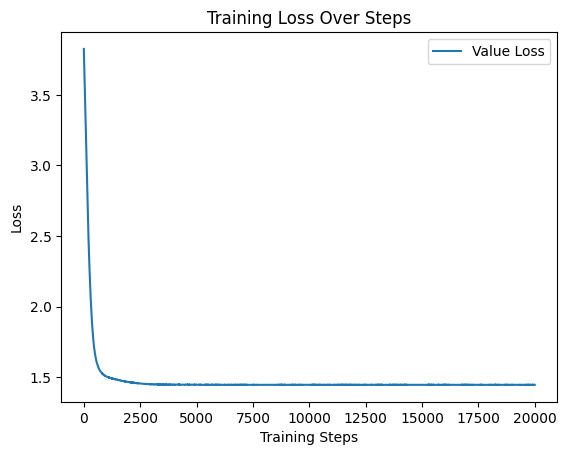

In [45]:
key, subkey = jax.random.split(key)
samples = jax.random.normal(subkey, (n_samples,dim))
opt = optax.adam(1e-3)
opt_state = opt.init(samples)
print("Sample shape", samples.shape)

# Training loop
@jax.jit
def train_step(samples, opt_state):
    value_loss, grads1 = jax.value_and_grad(loss_fn_entropy_values)(samples, means, stds_diag, true_entropies)
    gradient_loss, grads2 = jax.value_and_grad(loss_fn_entropy_gradients)(samples, means, stds_diag, true_entropy_grads_mu, true_entropy_grads_mu)
    grads = grads1 + 0*grads2  # Combine gradients for both losses
    updates, opt_state = opt.update(grads, opt_state)
    samples = optax.apply_updates(samples, updates)
    return samples, opt_state, value_loss, gradient_loss 

value_losses = []
gradient_losses = []
for i in tqdm.trange(20_000):
    samples, opt_state, loss1, loss2 = train_step(samples, opt_state)
    value_losses.append(loss1)
    gradient_losses.append(loss2)

print("Final learned samples (z):", (samples).sort())
plt.plot(value_losses, label='Value Loss')
# plt.plot(gradient_losses, label='Gradient Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Steps')
plt.legend()
plt.show()

### Learned Samples for fast MC entropy estimation 

In [46]:
if dim == 1:
    samples = samples.squeeze()
    print('Half set', [i.item() for i in samples.sort()])
    ## Mirror the smaples to make it symmetric around zero
    samples = jnp.concatenate([-samples[::-1], samples])  # Adding zero to ensure symmetry
    print('Full set', [i.item() for i in samples.sort()])

Half set [-1.2608293294906616, -1.2133342027664185, -0.4514565169811249, 0.10739301145076752, 0.10739489644765854, 0.5797147750854492, 0.579728901386261, 1.8561625480651855]
Full set [-1.8561625480651855, -1.2608293294906616, -1.2133342027664185, -0.579728901386261, -0.5797147750854492, -0.4514565169811249, -0.10739489644765854, -0.10739301145076752, 0.10739301145076752, 0.10739489644765854, 0.4514565169811249, 0.5797147750854492, 0.579728901386261, 1.2133342027664185, 1.2608293294906616, 1.8561625480651855]


In [ ]:
[-2.28250789642334, -1.9211180210113525, -1.3525558710098267, -1.0677014589309692, -0.8902221918106079, -0.8044639229774475, -0.7819824814796448, -0.7775918245315552, -0.777317225933075, -0.7008596658706665, -0.6292149424552917, -0.29937660694122314, -0.1358855664730072, -0.09546408802270889, -0.03650583326816559, -0.012498264200985432, 0.012498264200985432, 0.03650583326816559, 0.09546408802270889, 0.1358855664730072, 0.29937660694122314, 0.6292149424552917, 0.7008596658706665, 0.777317225933075, 0.7775918245315552, 0.7819824814796448, 0.8044639229774475, 0.8902221918106079, 1.0677014589309692, 1.3525558710098267, 1.9211180210113525, 2.28250789642334]

# Optimal samples for entorpy gradient estimation 

In [ ]:
import jax
import jax.numpy as jnp
from jax import grad, random
import optax

# ------------------------------------------
# Tanh Gaussian Entropy using Monte Carlo
# ------------------------------------------
def tanh_gaussian_entropy_mc(samples, mu, log_std):
    std = jnp.exp(log_std)
    z = mu + samples * std
    y = jnp.tanh(z)
    log_det_jacobian = jnp.sum(jnp.log(1 - jnp.square(y) + 1e-6), axis=-1)
    base_log_prob = -0.5 * jnp.sum(jnp.square(samples) + 2 * log_std + jnp.log(2 * jnp.pi), axis=-1)
    return -jnp.mean(base_log_prob - log_det_jacobian)

# ------------------------------------------
# True Entropy Gradient with Large Sample Set
# ------------------------------------------
def true_entropy_grad(mu, log_std, key, num_samples=10000):
    dim = mu.shape[0]
    samples = random.normal(key, shape=(num_samples, dim))
    entropy_fn = lambda m, l: tanh_gaussian_entropy_mc(samples, m, l)
    grad_mu = grad(entropy_fn, argnums=0)(mu, log_std)
    grad_log_std = grad(entropy_fn, argnums=1)(mu, log_std)
    return grad_mu, grad_log_std

# ------------------------------------------
# Estimated Entropy Gradient with Learned Samples
# ------------------------------------------
def estimated_entropy_grad(samples_learned, mu, log_std):
    entropy_fn = lambda m, l: tanh_gaussian_entropy_mc(samples_learned, m, l)
    grad_mu = grad(entropy_fn, argnums=0)(mu, log_std)
    grad_log_std = grad(entropy_fn, argnums=1)(mu, log_std)
    return grad_mu, grad_log_std

# ------------------------------------------
# Gradient Matching Loss Function
# ------------------------------------------
def gradient_matching_loss(samples_learned, mu, log_std, key):
    true_grad_mu, true_grad_log_std = true_entropy_grad(mu, log_std, key)
    est_grad_mu, est_grad_log_std = estimated_entropy_grad(samples_learned, mu, log_std)
    loss = jnp.sum((true_grad_mu - est_grad_mu) ** 2) + jnp.sum((true_grad_log_std - est_grad_log_std) ** 2)
    return loss

# ------------------------------------------
# Optimization Loop
# ------------------------------------------
def optimize_entropy_samples(dim=3, n_learned_samples=16, n_iters=1000, lr=1e-2, seed=0):
    key = random.PRNGKey(seed)
    mu = jnp.zeros((dim,))
    log_std = jnp.zeros((dim,))
    key, subkey = random.split(key)
    samples_learned = random.normal(subkey, shape=(n_learned_samples, dim))

    optimizer = optax.adam(lr)
    opt_state = optimizer.init(samples_learned)

    @jax.jit
    def step(samples, opt_state, key):
        loss, grads = jax.value_and_grad(gradient_matching_loss)(samples, mu, log_std, key)
        updates, opt_state = optimizer.update(grads, opt_state, samples)
        samples = optax.apply_updates(samples, updates)
        return samples, opt_state, loss

    losses = []
    for i in range(n_iters):
        key, subkey = random.split(key)
        samples_learned, opt_state, loss = step(samples_learned, opt_state, subkey)
        losses.append(loss)

    return samples_learned, losses

# Misc

In [ ]:
import jax
import jax.numpy as jnp

key = jax.random.PRNGKey(7)
samples = jax.random.normal(key, shape=(1_000_000,), dtype=jnp.float64)  # Example learned samples
samples = jnp.concatenate([-samples[::-1], samples, jnp.array([0])])  # Adding zero to ensure symmetry
samples = (samples - jnp.mean(samples)) / jnp.std(samples)  # Normalize samples

def f(x):
    return jnp.mean(jnp.log1p(-jnp.tanh(x * samples) ** 2)) + 0.5 * jnp.log(2 *jnp.pi *jnp.e * x**2)
def f_grad(x):
    return (1/x) + jnp.mean(-2 * jnp.tanh(x * samples) * samples)

@jax.jit
def update_f(x):
    x += 0.002*f_grad(x)
    return x

x_0 = 0.8744  # Initial value for x, very close to the optimal value
x_0 = jnp.array(x_0, dtype=jnp.float64)  # Ensure x_0 is a float64 for higher precision

for i in range(10_000):
    x_0 = update_f(x_0)
    if i%100==0:
        print(f"Iteration {i+1}, x: {x_0}")
print("Optimized x:", x_0)
print("Entropy value:", f(x_0))
print("Gradient value:", f_grad(x_0))

Iteration 1, x: 0.8744005687622104
Iteration 101, x: 0.8744477486715041
Iteration 201, x: 0.8744799446041801
Iteration 301, x: 0.8745019159428646
Iteration 401, x: 0.8745169100269383
Iteration 501, x: 0.8745271426921587
Iteration 601, x: 0.8745341260014181
Iteration 701, x: 0.8745388918067687
Iteration 801, x: 0.8745421442748413
Iteration 901, x: 0.8745443639578373
Iteration 1001, x: 0.8745458788079644
Iteration 1101, x: 0.8745469126374767
Iteration 1201, x: 0.874547618188712
Iteration 1301, x: 0.874548099702182
Iteration 1401, x: 0.8745484283180266
Iteration 1501, x: 0.8745486525867312
Iteration 1601, x: 0.8745488056422283
Iteration 1701, x: 0.8745489100972306
Iteration 1801, x: 0.8745489813841085
Iteration 1901, x: 0.8745490300349074
Iteration 2001, x: 0.8745490632373749
Iteration 2101, x: 0.8745490858968986
Iteration 2201, x: 0.8745491013612311
Iteration 2301, x: 0.8745491119150979
Iteration 2401, x: 0.8745491191177429
Iteration 2501, x: 0.8745491240332965
Iteration 2601, x: 0.87454

In [ ]:
0.8727344274520874 # 100
0.8727468252182007 # 100k
0.8743883967399597 # 10M
0.8744339942932129 # 100M
0.874382734298706  # 100M
0.8744062185287476 # 100M
0.8744085431098938 # 100M

0.8744062185287476